### About
* This is some prework before beignning Insight LA Sep 2020
* For this, i pulled stock data from 85 different biotech companies
* High,Low,Close,Volume daily data from 1974 to 2015
* I want to use the multivar time series to predict whether or not Pfizer's stock is up or down from the start of the month at the end of the month
* This also serves as an experimentatino notebook for my Insight demo, which will be predicit septic shock from ICU patients
* This is to test my methods

In [71]:
import quandl
import csv
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
key = '2ubHBg4pkVHEn5ivHGsL'
quandl.ApiConfig.api_key = key

In [1]:
!pip install tcn

ERROR: Could not find a version that satisfies the requirement tcn (from versions: none)
ERROR: No matching distribution found for tcn


In [2]:
#data = quandl.get("WIKI/ATRA", start_date="2015-01-31", end_date="2015-12-31",collapse="daily")
data = quandl.get("WIKI/FOLD")

In [3]:
data['Company'] = ['FOLD' for i in range(data.shape[0])]
data

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,Company
Date,,,,,,,,,,,,,
2007-05-31,16.00,16.800,14.250,14.430,3874200.0,0.0,1.0,16.00,16.800,14.250,14.430,3874200.0,FOLD
2007-06-01,14.40,14.750,13.100,13.500,606200.0,0.0,1.0,14.40,14.750,13.100,13.500,606200.0,FOLD
2007-06-04,13.89,16.000,13.530,13.800,162700.0,0.0,1.0,13.89,16.000,13.530,13.800,162700.0,FOLD
2007-06-05,13.52,14.430,13.500,14.020,86500.0,0.0,1.0,13.52,14.430,13.500,14.020,86500.0,FOLD
2007-06-06,13.83,14.140,13.830,14.000,58000.0,0.0,1.0,13.83,14.140,13.830,14.000,58000.0,FOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,14.47,15.050,14.300,14.870,2595120.0,0.0,1.0,14.47,15.050,14.300,14.870,2595120.0,FOLD
2018-03-22,14.63,15.030,14.120,14.125,1858148.0,0.0,1.0,14.63,15.030,14.120,14.125,1858148.0,FOLD
2018-03-23,14.28,14.849,14.025,14.060,1551454.0,0.0,1.0,14.28,14.849,14.025,14.060,1551454.0,FOLD


### Problem Statment
* Predict whether or not Pfizer stock will be up or down from the previous month
* Get other pharma compnies data
* Use daily O,H,L,C
* Need to add whether or not it if was up or down from the previous month
* many to many relationship to get the closing prices
* so predict closeing at the end of the day
* use 7 years data?

In [156]:
#biotech companies stock abbreviations
biotech = []
with open('biotech_companies.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for i,r in enumerate(csv_reader):
        if i == 25:
            break
        print(r)

['\ufeff2', 'AC IMMUNE SA CM', 'ACIU']
['1', 'ACADIA PHARMACEUTICA', 'ACAD']
['100', 'ACCELERON PHARMA CMN', 'XLRN']
['4', 'ADAPTIVE BIOTECH CMN', 'ADPT']
['3', 'ADMA BIOLOGICS CMN', 'ADMA']
['5', 'ADVERUM BIOTECHNLGS', 'ADVM']
['9', 'AEGLEA BIOTHERA CM', 'AGLE']
['6', 'AERIE PHARMACEUTICAL', 'AERI']
['7', 'AFFIMED N.V.', 'AFMD']
['8', 'AGIOS PHARMACEUTICAL', 'AGIO']
['10', 'AIMMUNE THERAP CMN', 'AIMT']
['12', 'AKCEA THERAPUTIC CM', 'AKCA']
['11', 'AKEBIA THERAPEUTICS', 'AKBA']
['13', 'AKERO THERAPEUTIC CM', 'AKRO']
['14', 'ALECTOR, INC CMN STK', 'ALEC']
['19', 'ALEXION PHARM INC', 'ALXN']
['15', 'ALKERMES PLC', 'ALKS']
['16', 'ALLAKOS INC.', 'ALLK']
['17', 'ALLOGENE THER CM', 'ALLO']
['18', 'ALNYLAM PHARMACEUT', 'ALNY']
['20', 'AMAG PHARMACEUTICALS', 'AMAG']
['23', 'AMARIN CORP ADS', 'AMRN']
['21', 'AMGEN', 'AMGN']
['84', 'AMICUS THERAPEUTICS', 'FOLD']
['22', 'AMPHASTAR PHARMA CMN', 'AMPH']


In [177]:
#biotech companies stock abbreviations
biotech = []
with open('biotech_companies.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for r in csv_reader:
        biotech.append(r[-1])


* For each company, pull the data, convert to datafram
* add to list of frames
* clean by agging columns with companyname
* Add in column saying whether or not the company was up or down from the start of the month
* i.e first recording day in month opening - last recorded day in month ending

In [178]:
frames = []
for i,b in enumerate(biotech):
    try:
        data = quandl.get("WIKI/"+b)
        data['Company'] = [b for i in range(data.shape[0])]
        frames.append(data)
        print('At the '+str(i)+' th '+' one '+b)
        time.sleep(2)
    except:
        pass
        time.sleep(2)

for i in range(0,len(frames)):
    frames[i] = frames[i].reset_index()
    frames[i] = frames[i][['Date', 'Open', 'High', 'Low', 'Close','Volume','Company']]
    #add month yearcol for easy access
    frames[i]['YearMonth'] = frames[i]['Date'].apply(lambda x: x.strftime('%b-%Y')) 
    #need to add if it was up or down from the start of the month?
    #init up down vector 1 is up
    results = []
    month_year_range = frames[i]['YearMonth'].unique()
    for date in month_year_range:
        #subset
        subset = frames[i][frames[i]['YearMonth'] == date]
        #pull open start month and close end month and get difference
        difference = subset['Close'].iloc[-1] - subset['Open'].iloc[0]
        if difference > 0:
            results += [1 for _ in range(subset.shape[0])]
        else:
            results += [0 for _ in range(subset.shape[0])]
    #add in results column
    frames[i]['UpOrDownMonthEnd'] = results
    #reorder columns
    frames[i] = frames[i][['Date','YearMonth','Open', 'High', 'Low', 'Close', 'Volume', 'UpOrDownMonthEnd','Company']]
    #add company name to OpenHighLowClose
    name = frames[i]['Company'][0]
    colnames = ['Date','YearMonth'] + [name+"_"+foo for foo in ['Open', 'High', 'Low','Close','Volume','UpOrDownMonthEnd','Company']]
    frames[i].columns = colnames
    frames[i] = frames[i].iloc[:,:-1]

#merged frames
merged_frame = frames[0]
for i in range(1,len(frames)):
    merged_frame = merged_frame.merge(frames[i],on=['Date','YearMonth'],how='outer')
    
#save to csv files
merged_frame.to_csv('85_biotech_companies_timeseries.csv')


At the 1 th  one ACAD
At the 2 th  one XLRN
At the 7 th  one AERI
At the 9 th  one AGIO
At the 12 th  one AKBA
At the 15 th  one ALXN
At the 16 th  one ALKS
At the 19 th  one ALNY
At the 20 th  one AMAG
At the 22 th  one AMGN
At the 23 th  one FOLD
At the 25 th  one AMRS
At the 27 th  one ANIP
At the 30 th  one ARNA
At the 32 th  one ARWR
At the 45 th  one TECH
At the 46 th  one BCRX
At the 47 th  one BDSI
At the 48 th  one BIIB
At the 49 th  one BMRN
At the 50 th  one BLUE
At the 53 th  one CARA
At the 56 th  one CERS
At the 57 th  one CCXI
At the 66 th  one CYTK
At the 70 th  one DRNA
At the 75 th  one ENTA
At the 76 th  one ENDP
At the 77 th  one EPZM
At the 78 th  one ESPR
At the 80 th  one EXEL
At the 84 th  one FLXN
At the 88 th  one GERN
At the 89 th  one GILD
At the 97 th  one HALO
At the 99 th  one HZNP
At the 101 th  one ILMN
At the 102 th  one IMGN
At the 103 th  one IMMU
At the 104 th  one INCY
At the 106 th  one INO
At the 107 th  one INSM
At the 109 th  one ICPT
At the 11

In [152]:
biotech = pd.read_csv("85_biotech_companies_timeseries.csv",index_col=0)

In [153]:
print(biotech.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11557 entries, 0 to 11556
Columns: 512 entries, Date to PFE_UpOrDownMonthEnd
dtypes: float64(510), object(2)
memory usage: 45.2+ MB
None


Lets examin some of the time series for the most recent year

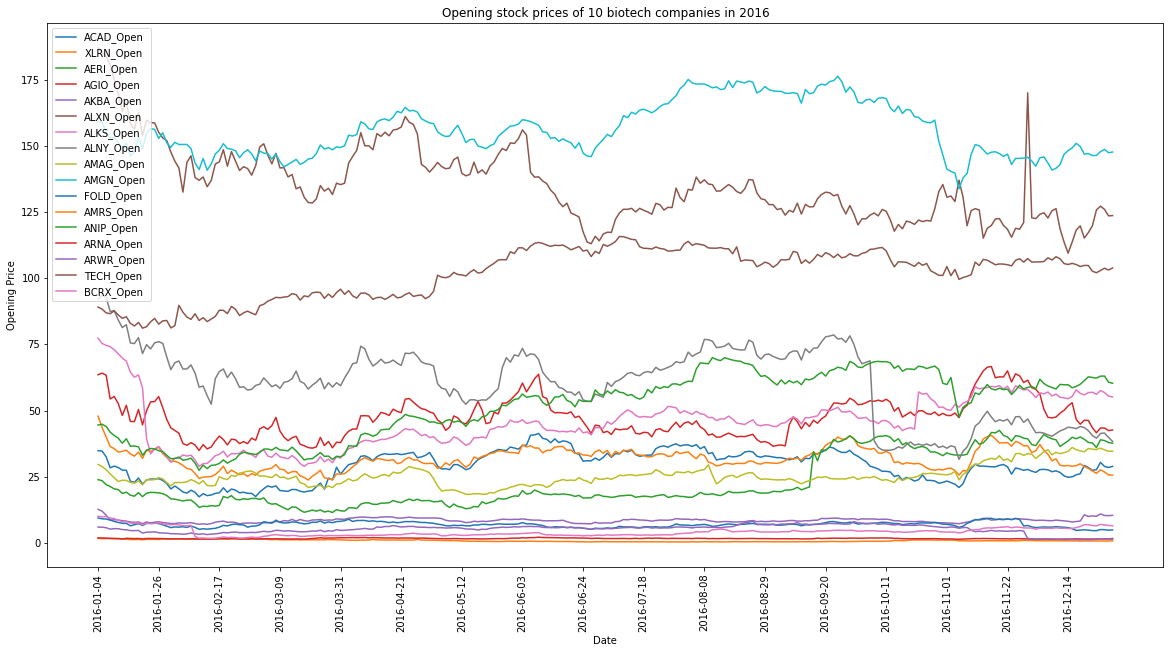

In [154]:
test = biotech[biotech['YearMonth'].str.contains('2016')]
columns_to_plot = [test.columns[2:][i] for i in range(0,len(test.columns[2:]),6)][:17]
plt.figure(figsize=(20,10))
for c in columns_to_plot:
    plt.plot(test['Date'],test[c],label=c)
plt.xticks([test['Date'].iloc[i] for i in range(0,len(test['Date']),15)],rotation='vertical')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Opening Price')
plt.title('Opening stock prices of 10 biotech companies in 2016')
plt.show()

### Plot volume Traded

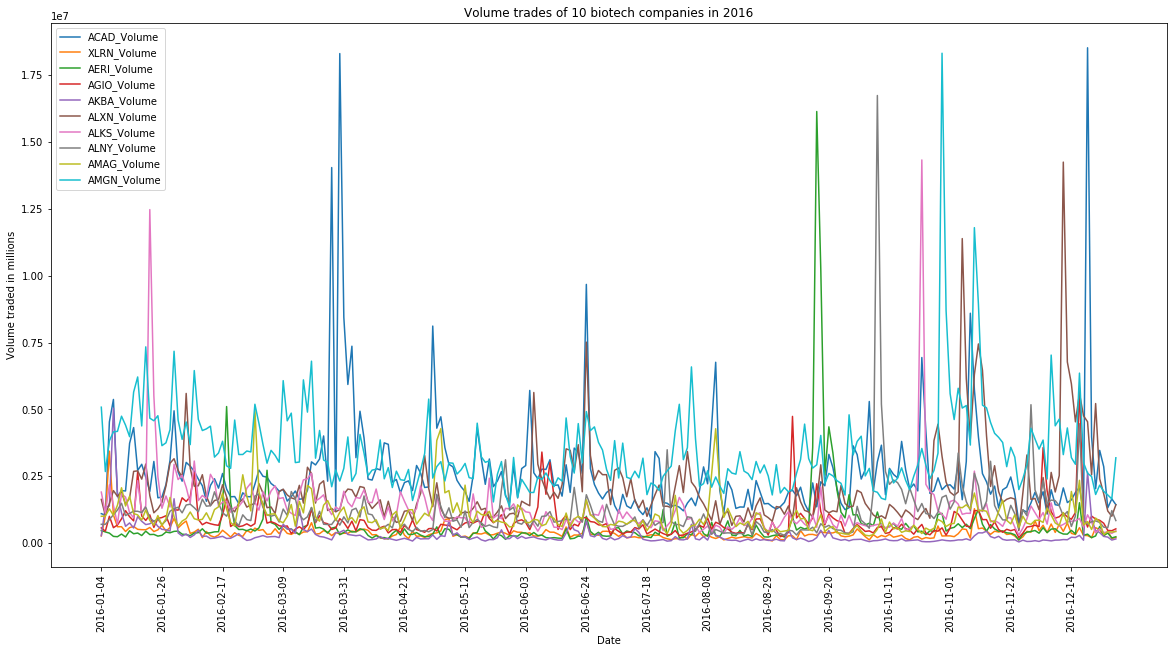

In [155]:
columns_to_plot = [test.columns[6:][i] for i in range(0,len(test.columns[2:]),6)][:10]
plt.figure(figsize=(20,10))
for c in columns_to_plot:
    plt.plot(test['Date'],test[c],label=c)
plt.xticks([test['Date'].iloc[i] for i in range(0,len(test['Date']),15)],rotation='vertical')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Volume traded in millions')
plt.title('Volume trades of 10 biotech companies in 2016')
plt.show()

### Plot Difference between open and close

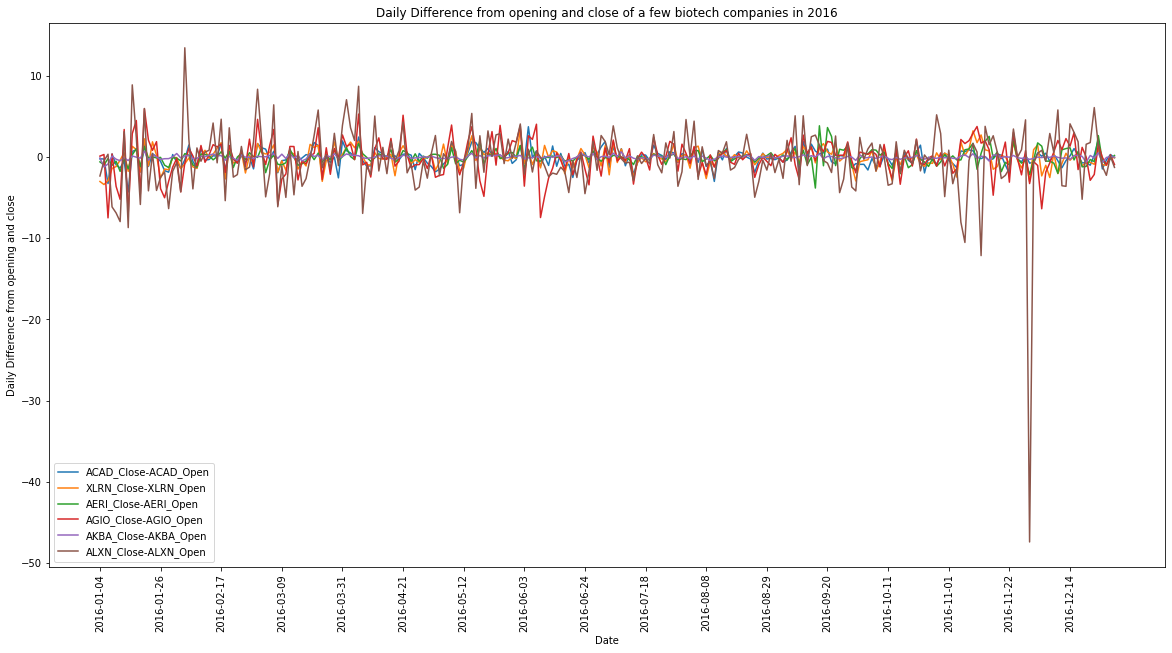

In [156]:
cols = [(test.columns[2:][i],test.columns[2:][i+3]) for i in range(0,len(test.columns[2:]),6)][:6]
plt.figure(figsize=(20,10))
for OPEN,CLOSE in cols:
    plt.plot(test['Date'],test[CLOSE] - test[OPEN],label=CLOSE+"-"+OPEN)
plt.xticks([test['Date'].iloc[i] for i in range(0,len(test['Date']),15)],rotation='vertical')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Daily Difference from opening and close')
plt.title('Daily Difference from opening and close of a few biotech companies in 2016')
plt.show()

### We wanted to see if we could preidct whether Pfizer's stock would be up or down at the end of the month from the start of the month? 
*  Lets soo how the prices of other companies affected Pfizer

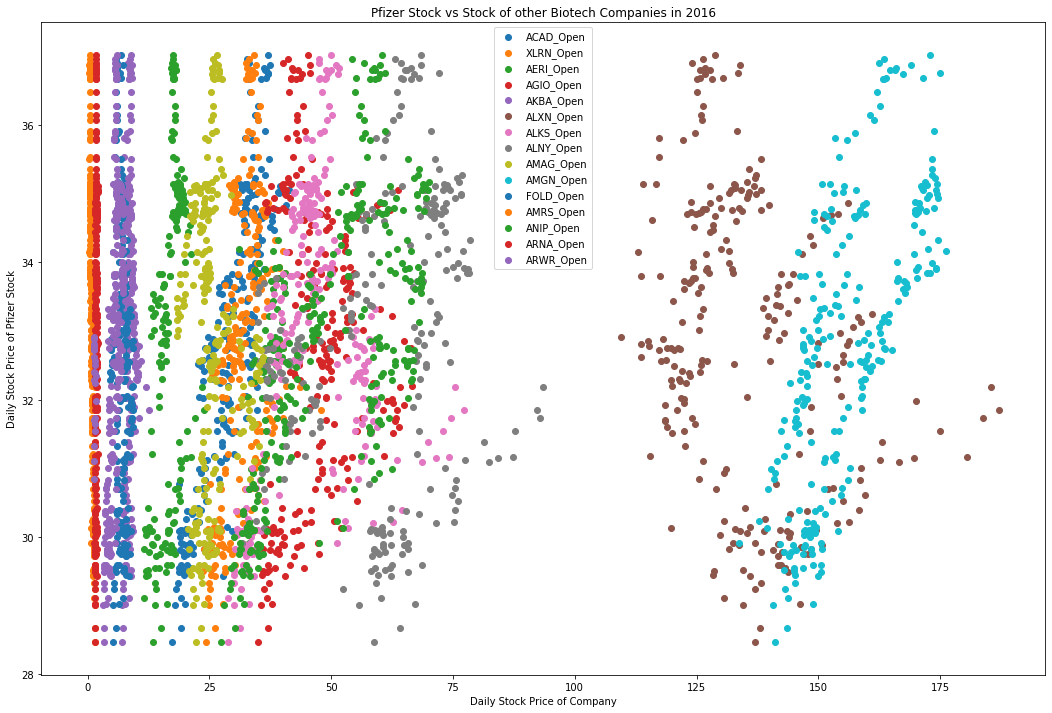

In [157]:
cols = [test.columns[2:][i] for i in range(0,len(test.columns[2:]),6)][:-1][:15]
plt.figure(figsize=(18,12))
for c in cols:
    plt.scatter(test[c],test['PFE_Open'],label=c)
plt.legend()
plt.xlabel('Daily Stock Price of Company')
plt.ylabel('Daily Stock Price of Pfizer Stock')
plt.title('Pfizer Stock vs Stock of other Biotech Companies in 2016')
plt.show()

* It looks like I they are all roughly linear
* I could make a cool visual where I do multiple linear regressions for each stock company? Maybe later
* Instead,Lets get the covariance matrix, don't use a package, use this:

$
Cov(X) = X - 11'X(1/n) \\
Cov(X) = Cov(X)Cov(X)'
$

* grab all columns but the up or down ones


In [158]:
cols = [test.columns[2:][i] for i in range(0,len(test.columns[2:])) if "End" not in test.columns[2:][i]]
X = test[cols].values
X = X - np.dot(np.ones((X.shape[0],X.shape[0])),X) / X.shape[0]
X = np.dot(X.T,X)
X.shape

(425, 425)

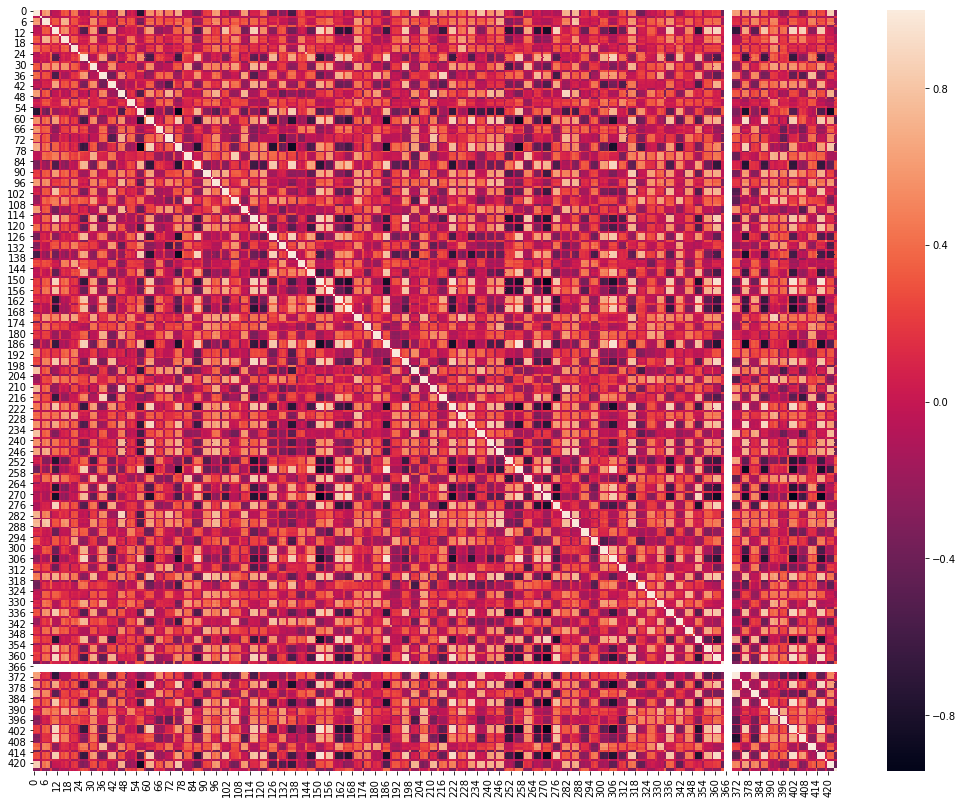

In [159]:
plt.figure(figsize=(18,14))
sns.heatmap(test[cols].corr().values)

* Now we can get the correlation matrix

$
X_{ij} = \frac{X_{ij}}{\sigma_{i}\sigma_{j}}
$

### Modeling
* use multivariate time series to predict whether or not PFE stock will be up or down from the start of the month
* for this experiment i don't want top NaN values
* impute them linearly, then up or down are just zeros all the way through, oh well

In [160]:
biotech = biotech.sort_values('Date').reset_index()
biotech

,index,Date,YearMonth,ACAD_Open,ACAD_High,ACAD_Low,ACAD_Close,ACAD_Volume,ACAD_UpOrDownMonthEnd,XLRN_Open,...,XNCR_Low,XNCR_Close,XNCR_Volume,XNCR_UpOrDownMonthEnd,PFE_Open,PFE_High,PFE_Low,PFE_Close,PFE_Volume,PFE_UpOrDownMonthEnd
0,8458,1972-06-01,Jun-1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,41.22,41.2500,40.62,41.25,48600.0,1.0
1,8459,1972-06-02,Jun-1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,41.25,41.3800,40.62,40.75,31900.0,1.0
2,8460,1972-06-05,Jun-1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,40.75,40.8700,40.38,40.62,51100.0,1.0
3,8461,1972-06-06,Jun-1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,40.62,41.7500,40.50,41.50,46400.0,1.0
4,8462,1972-06-07,Jun-1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,41.50,41.5000,40.87,41.50,20400.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11552,3476,2018-03-21,Mar-2018,24.53,24.9400,24.250,24.66,1105427.0,0.0,42.21,...,29.53,30.98,3901210.0,0.0,36.49,36.7300,36.20,36.27,16405382.0,0.0
11553,3477,2018-03-22,Mar-2018,24.45,24.7890,23.760,23.84,1243951.0,0.0,42.85,...,30.00,30.32,564748.0,0.0,36.03,36.1433,35.47,35.60,20288017.0,0.0
11554,3478,2018-03-23,Mar-2018,23.63,23.9500,22.470,22.57,2387381.0,0.0,41.36,...,29.95,30.44,321017.0,0.0,35.49,35.5000,34.44,34.49,27489780.0,0.0
11555,3479,2018-03-26,Mar-2018,23.02,23.6400,22.540,23.54,1612893.0,0.0,40.29,...,30.24,31.08,801972.0,0.0,34.93,35.1500,34.32,35.04,23464967.0,0.0


In [161]:
#define function to interpolate across a column
def interpolate(array):
    #scan once up to the first value, interpolate, and put back into array,input is list
    first_non_nan_idx = None
    for i in range(0,len(array)):
        if np.isnan(array[i]) == False:
            last_nan_idx = i
            break
    for i in range(0,last_nan_idx):
        array[i] = (i / last_nan_idx)*array[last_nan_idx]
    return array

#apply over the whole function
cols = [col for col in biotech.columns[3:] if 'End' not in col]
for c in cols:
    array = interpolate(list(biotech[c]))
    biotech[c] = array
     

In [162]:
#fill in missling labels, for the previous value we imputed, since they aren't technically down, classify as up
#so fill in ones
cols = [col for col in biotech.columns[3:] if 'End' in col]
for c in cols:
    biotech[c] = biotech[c].fillna(value=1.0)

In [163]:
'PFE_UpOrDownMonthEnd'
cols = [col for col in biotech.columns[1:] if 'End' not in col]
cols += ['PFE_UpOrDownMonthEnd']
biotech = biotech[cols]
biotech

,Date,YearMonth,ACAD_Open,ACAD_High,ACAD_Low,ACAD_Close,ACAD_Volume,XLRN_Open,XLRN_High,XLRN_Low,...,XNCR_High,XNCR_Low,XNCR_Close,XNCR_Volume,PFE_Open,PFE_High,PFE_Low,PFE_Close,PFE_Volume,PFE_UpOrDownMonthEnd
0,1972-06-01,Jun-1972,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,41.22,41.2500,40.62,41.25,48600.0,1.0
1,1972-06-02,Jun-1972,0.000921,0.000929,0.000805,0.000830,2.376424e+02,0.001775,0.001996,0.001775,...,0.000809,0.000549,0.000796,1.794786e+02,41.25,41.3800,40.62,40.75,31900.0,1.0
2,1972-06-05,Jun-1972,0.001842,0.001857,0.001610,0.001659,4.752848e+02,0.003551,0.003992,0.003551,...,0.001618,0.001098,0.001593,3.589572e+02,40.75,40.8700,40.38,40.62,51100.0,1.0
3,1972-06-06,Jun-1972,0.002764,0.002786,0.002415,0.002489,7.129272e+02,0.005326,0.005988,0.005326,...,0.002426,0.001647,0.002389,5.384358e+02,40.62,41.7500,40.50,41.50,46400.0,1.0
4,1972-06-07,Jun-1972,0.003685,0.003715,0.003219,0.003318,9.505696e+02,0.007102,0.007985,0.007102,...,0.003235,0.002196,0.003186,7.179144e+02,41.50,41.5000,40.87,41.50,20400.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11552,2018-03-21,Mar-2018,24.530000,24.940000,24.250000,24.660000,1.105427e+06,42.210000,43.899900,40.910000,...,31.100000,29.530000,30.980000,3.901210e+06,36.49,36.7300,36.20,36.27,16405382.0,0.0
11553,2018-03-22,Mar-2018,24.450000,24.789000,23.760000,23.840000,1.243951e+06,42.850000,43.375000,41.170000,...,31.643300,30.000000,30.320000,5.647480e+05,36.03,36.1433,35.47,35.60,20288017.0,0.0
11554,2018-03-23,Mar-2018,23.630000,23.950000,22.470000,22.570000,2.387381e+06,41.360000,41.810000,39.375000,...,31.180000,29.950000,30.440000,3.210170e+05,35.49,35.5000,34.44,34.49,27489780.0,0.0
11555,2018-03-26,Mar-2018,23.020000,23.640000,22.540000,23.540000,1.612893e+06,40.290000,41.520000,39.250000,...,31.330000,30.240000,31.080000,8.019720e+05,34.93,35.1500,34.32,35.04,23464967.0,0.0


### X and Y creation
* Y is simply the PFE up or down column
* we want the window to a maximum of 31 days
* for the months less than 31 days forward fill, dont forget to add in the extra labels!
* shape would be (num_samples, 23, 425)
* looks like the longest sequence is 23
* for months less than 23, forward fill

550

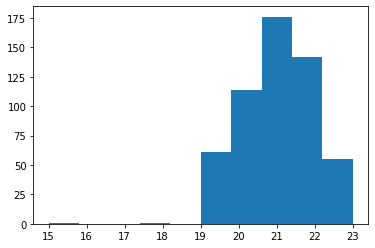

In [180]:
dims = []
for a,b in biotech.groupby('YearMonth'):
    dims.append(b.shape[0])
plt.hist(dims)
len(dims)

* create X list, dump in X
* create Y list
* traverse groupy iterator
* if shape[0] less than 23, forward fill all into 23
* forward fill Y appropriately
* put into X
* put into Y

In [238]:
X_s = np.zeros((550,23,425))
y_s = np.zeros((550,23))
i = 0
for a,b in biotech.groupby('YearMonth'):
    #pull corresposnidng X and y
    X,y = b.iloc[:,2:-1].values, b.iloc[:,-1].values
    #is less than 23
    if X.shape[0] < 23:
        #concat with the last number of rows
        for i in range(23-X.shape[0]):
            X = np.vstack((X,X[-1,:]))
            y = np.hstack((y,y[-1].reshape((1,))))
    X_s[i,:,:] = X
    y_s[i,:] = y
    i += 1


    

In [391]:
y_s.shape,X_s.shape

((550, 23), (550, 23, 425))

In [243]:
X_s.reshape((1,550, 23, 425)).shape

(1, 550, 23, 425)

Great! Now lets try using a keras LSTM to predict the sequences!

The bottom part if my trying to see if i can grab some of the hiddens states, and its looks like i can

https://www.dlology.com/blog/how-to-use-return_state-or-return_sequences-in-keras/

https://keras.io/guides/functional_api/

https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/

https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras-part-2/

In [543]:
from keras.models import Model
from keras.layers import Input,Dense
from keras.layers import LSTM
import tensorflow as tf
import keras
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
from keras.layers import TimeDistributed

k_init = keras.initializers.Constant(value=0.1)
b_init = keras.initializers.Constant(value=0)
r_init = keras.initializers.Constant(value=0.1)
# LSTM units
units = 3

# define model
inputs1 = Input(shape=(23, 425))
lstm1, state_h, state_c = LSTM(32, return_sequences=True, return_state=True)(inputs1)
hidden_state_preds = Dense(1,activation='sigmoid')(lstm1)
last_step_preds = Dense(1,activation='sigmoid')(state_c)
model = Model(inputs=inputs1, outputs=[hidden_state_preds,last_step_preds])

output = model.predict(X_s[107,:,:].reshape((1,23,425)))
print(output)

[array([[[0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5],
        [0.5]]], dtype=float32), array([[0.5]], dtype=float32)]


In [560]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_110 (InputLayer)          (None, 23, 425)      0                                            
__________________________________________________________________________________________________
lstm_118 (LSTM)                 [(None, 23, 32), (No 58624       input_110[0][0]                  
__________________________________________________________________________________________________
dense_98 (Dense)                (None, 23, 1)        33          lstm_118[0][0]                   
__________________________________________________________________________________________________
dense_99 (Dense)                (None, 1)            33          lstm_118[0][2]                   
Total params: 58,690
Trainable params: 58,690
Non-trainable params: 0
_______________________________________

In [545]:
y_s[:,-1].shape

(550,)

In [546]:
y_s.shape

(550, 23)

In [549]:
# compile the model
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.SGD(lr=0.0001),
    metrics=["accuracy"],
)

# keep track of the results
history = model.fit(X_s,
                    [y_s.reshape((550,23,1)),y_s[:,-1]], 
                    batch_size=32,
                    epochs=50)

Epoch 1/50
550/550 [==============================] - 8s 15ms/step - loss: nan - dense_98_loss: nan - dense_99_loss: nan - dense_98_acc: 0.0000e+00 - dense_99_acc: 0.0000e+00
Epoch 2/50
550/550 [==============================] - 1s 2ms/step - loss: nan - dense_98_loss: nan - dense_99_loss: nan - dense_98_acc: 0.0000e+00 - dense_99_acc: 0.0000e+00
Epoch 3/50
550/550 [==============================] - 1s 2ms/step - loss: nan - dense_98_loss: nan - dense_99_loss: nan - dense_98_acc: 0.0000e+00 - dense_99_acc: 0.0000e+00
Epoch 4/50
550/550 [==============================] - 1s 2ms/step - loss: nan - dense_98_loss: nan - dense_99_loss: nan - dense_98_acc: 0.0000e+00 - dense_99_acc: 0.0000e+00
Epoch 5/50
550/550 [==============================] - 1s 2ms/step - loss: nan - dense_98_loss: nan - dense_99_loss: nan - dense_98_acc: 0.0000e+00 - dense_99_acc: 0.0000e+00
Epoch 6/50
550/550 [==============================] - 1s 2ms/step - loss: nan - dense_98_loss: nan - dense_99_loss: nan - dense_9

In [573]:
model.layers[3].get_weights()

[array([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], dtype=float32),
 array([nan], dtype=float32)]

### Another way

https://stackoverflow.com/questions/42804966/convert-sequential-to-functional-in-keras

In [492]:
X_s.shape,y_s.shape

((550, 23, 425), (550, 23))

In [355]:
model.output

[<tf.Tensor 'lstm_53/transpose_1:0' shape=(?, ?, 1) dtype=float32>,
 <tf.Tensor 'lstm_53/while/Exit_3:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'lstm_53/while/Exit_4:0' shape=(?, 1) dtype=float32>]

* the ys need to be ia list of three [the sequence,ending,ending]
* i need to restructure
* for m in samples
    * mth sequence, which is just y_s[mth]

In [370]:
new_y = [y_s.reshape((550,23)),y_s[:,-1].reshape((1,550)),y_s[:,-1]]

In [360]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        (None, 23, 425)           0         
_________________________________________________________________
lstm_53 (LSTM)               [(None, 23, 1), (None, 1) 1708      
Total params: 1,708
Trainable params: 1,708
Non-trainable params: 0
_________________________________________________________________


In [367]:
y_s.shape

(550, 23)

In [264]:
del tf